## Sign Language Image Classification using Deep Learning

### 1. Load and inspect the data 

We will use a dataset that contains images of hands in poses corresponding to letters in Amercian Sign Language. Each image is small (similar to MNIST size) and we will build a CNN classifier (using Keras) to determine the corresponding letter for an image. 

In [1]:
### Your code and answers here
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# load the data
train_data = pd.read_csv('sign_mnist_train.csv')
test_data = pd.read_csv('sign_mnist_test.csv')
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [2]:
#3 data information
print('The shape of the train dataset:' + str(train_data.shape))
print('The shape of the test dataset:' + str(test_data.shape))

The shape of the train dataset:(27455, 785)
The shape of the test dataset:(7172, 785)


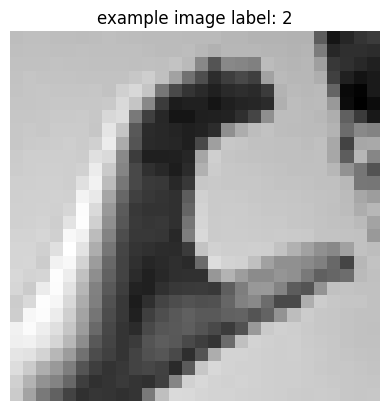

In [3]:
import matplotlib.pyplot as plt
# looke an example image(second one in train dataset)
plt.imshow(train_data.iloc[2, 1:,].values.reshape(28, 28),cmap ='gray')
plt.title('example image label: ' + str(train_data.iloc[2, 0]))
plt.axis('off')
plt.show()

In [4]:
# count how many labels and number of images in each labels in the train data set
train_data['label'].value_counts().sort_index()

label
0     1126
1     1010
2     1144
3     1196
4      957
5     1204
6     1090
7     1013
8     1162
10    1114
11    1241
12    1055
13    1151
14    1196
15    1088
16    1279
17    1294
18    1199
19    1186
20    1161
21    1082
22    1225
23    1164
24    1118
Name: count, dtype: int64

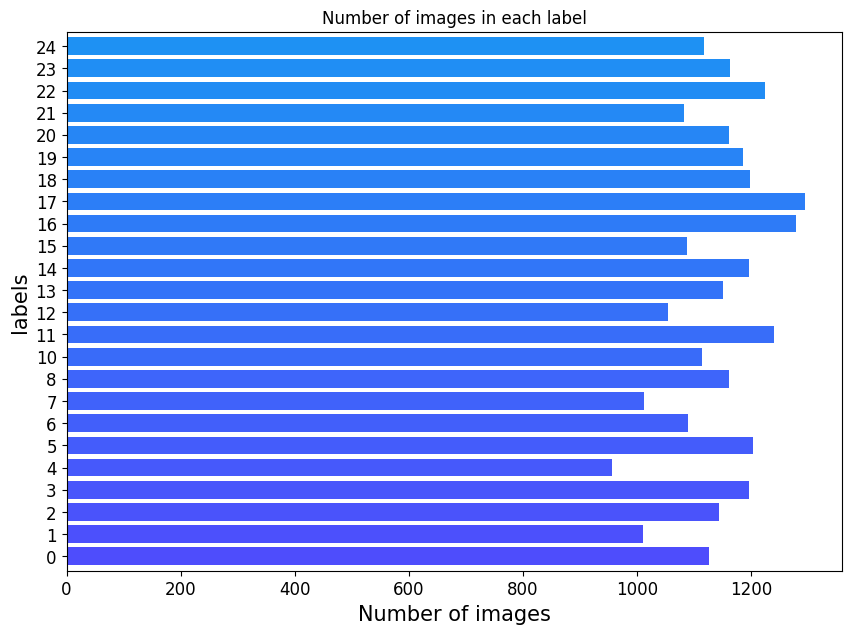

In [5]:
# Visulise the labels
from matplotlib import cm
import numpy as np
Count_label = train_data['label'].value_counts().sort_index()
plt.figure(figsize=(10,7))
color = cm.rainbow(np.linspace(0.1,0.3))
Count_label.plot(kind='barh',width=0.8,color = color,fontsize=12)
plt.title('Number of images in each label')
plt.ylabel('labels',fontsize=15)
plt.xlabel('Number of images',fontsize=15)
plt.show()

* From the graph and table above, we find that the data is well balanced.

In [6]:
# Pre-process the images so all pixels are between 0 and 1
X_train = train_data.iloc[:, 1:].values/255
X_train= np.reshape(X_train, (len(X_train), 28, 28, 1)).astype('float32')
y_train = train_data.iloc[:, 0].values
y_train = y_train.reshape(-1,1).astype('float32')
X_test_full = test_data.iloc[:, 1:].values/255
y_test_full = test_data.iloc[:, 0].values

In [7]:
# Create a validation set by the first 10% of the test data
X_valid,X_test = X_test_full[:710],X_test_full[710:]
X_valid,X_test = np.reshape(X_valid, (len(X_valid), 28, 28, 1)).astype('float32'),np.reshape(X_test, (len(X_test), 28, 28, 1)).astype('float32')
y_valid,y_test = y_test_full[:710],y_test_full[710:]
y_valid,y_test = y_valid.reshape(-1,1).astype('float32'),y_test.reshape(-1,1).astype('float32')

### 2. Build and train a CNN 
1. Build a CNN using Keras that has the following settings: 
 - Layers: Conv32 - MaxPooling - Conv64 - MaxPooling - Conv128 - Flatten - Dense(100) - Output
    - Note that Conv32 means a convolutional layer with 32 filters, etc.
 - 3x3 kernel size,
 - ReLU activation functions for hidden layers,
 - No dropout layers,
 - No BatchNorm layers.

In [8]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [9]:
### Your code and answers here
# generate Conv32 - MaxPooling - Conv64 - MaxPooling - Conv128 - Flatten - Dense(100) - Output
def generate_CNN():
    model = Sequential()
    model.add(Conv2D(32, kernel_size= 3,activation='relu', padding="same",input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size= 3, padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size= 3, padding="same", activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(25, activation='softmax'))
    return model

In [10]:
#summaray of the model we generate
model = generate_CNN()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 6272)              0

In [11]:
max_epochs = 10
# Nadam optimiser and default learning rate
model.compile(optimizer=keras.optimizers.Nadam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True) 

In [12]:
history = model.fit(X_train, y_train, epochs=max_epochs,callbacks = [early_stopping], validation_data = (X_valid,y_valid))

Epoch 1/10
858/858 [==============================] - 18s 20ms/step - loss: 0.4875 - accuracy: 0.8543 - val_loss: 0.5571 - val_accuracy: 0.8620
Epoch 2/10
858/858 [==============================] - 17s 20ms/step - loss: 0.0089 - accuracy: 0.9983 - val_loss: 0.6545 - val_accuracy: 0.8746
Epoch 3/10
858/858 [==============================] - 17s 20ms/step - loss: 3.3445e-04 - accuracy: 1.0000 - val_loss: 0.7088 - val_accuracy: 0.8775
Epoch 4/10
858/858 [==============================] - 17s 20ms/step - loss: 0.0716 - accuracy: 0.9813 - val_loss: 0.5249 - val_accuracy: 0.8718
Epoch 5/10
858/858 [==============================] - 17s 20ms/step - loss: 0.0048 - accuracy: 0.9989 - val_loss: 0.6199 - val_accuracy: 0.8718
Epoch 6/10
858/858 [==============================] - 17s 20ms/step - loss: 0.0074 - accuracy: 0.9981 - val_loss: 0.5501 - val_accuracy: 0.8817
Epoch 7/10
858/858 [==============================] - 18s 21ms/step - loss: 6.9977e-05 - accuracy: 1.0000 - val_loss: 0.6031 - val_a

In [13]:
#the function plot learning curves
def plot_history(h,title):
    plt.figure(figsize=(12,3))
    plt.subplot(121)
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.legend(("train accuracy","test accuracy"))
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.subplot(122)
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.legend(("train loss","test loss"))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.suptitle(title,fontsize=15)
    plt.show()

In [14]:
# the performance values of our model
eval_results = model.evaluate(X_test, y_test, verbose=0) 
print("Loss on test data: " + str(round(eval_results[0],2)))
print("Accuracy on test data: "   +'%s%%'%(round(eval_results[1]*100,2)))

Loss on test data: 0.52
Accuracy on test data: 90.11%


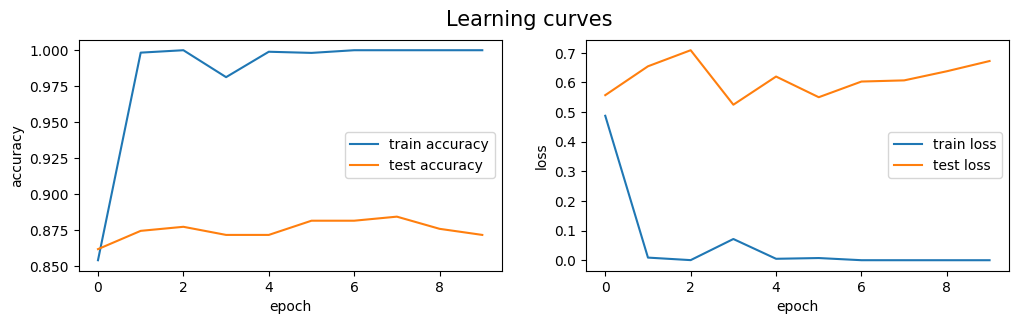

In [15]:
plot_history(history,'Learning curves')

In [16]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
# accuracy of each class our model predicted
y_pred =np.argmax(model.predict(X_test), axis=-1)
cm = multilabel_confusion_matrix(y_test,y_pred)
print( classification_report(y_test,y_pred))

202/202 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       302
         1.0       1.00      0.98      0.99       393
         2.0       1.00      0.95      0.97       279
         3.0       0.84      1.00      0.91       219
         4.0       0.93      1.00      0.96       448
         5.0       0.93      1.00      0.96       222
         6.0       0.90      0.79      0.84       314
         7.0       0.88      0.93      0.90       395
         8.0       0.94      0.92      0.93       256
        10.0       0.96      0.87      0.92       302
        11.0       0.91      1.00      0.95       192
        12.0       1.00      0.85      0.92       346
        13.0       0.83      0.81      0.82       268
        14.0       0.92      0.78      0.84       221
        15.0       0.95      0.90      0.92       304
        16.0       0.67      1.00      0.81       151
        17.0       0.98   

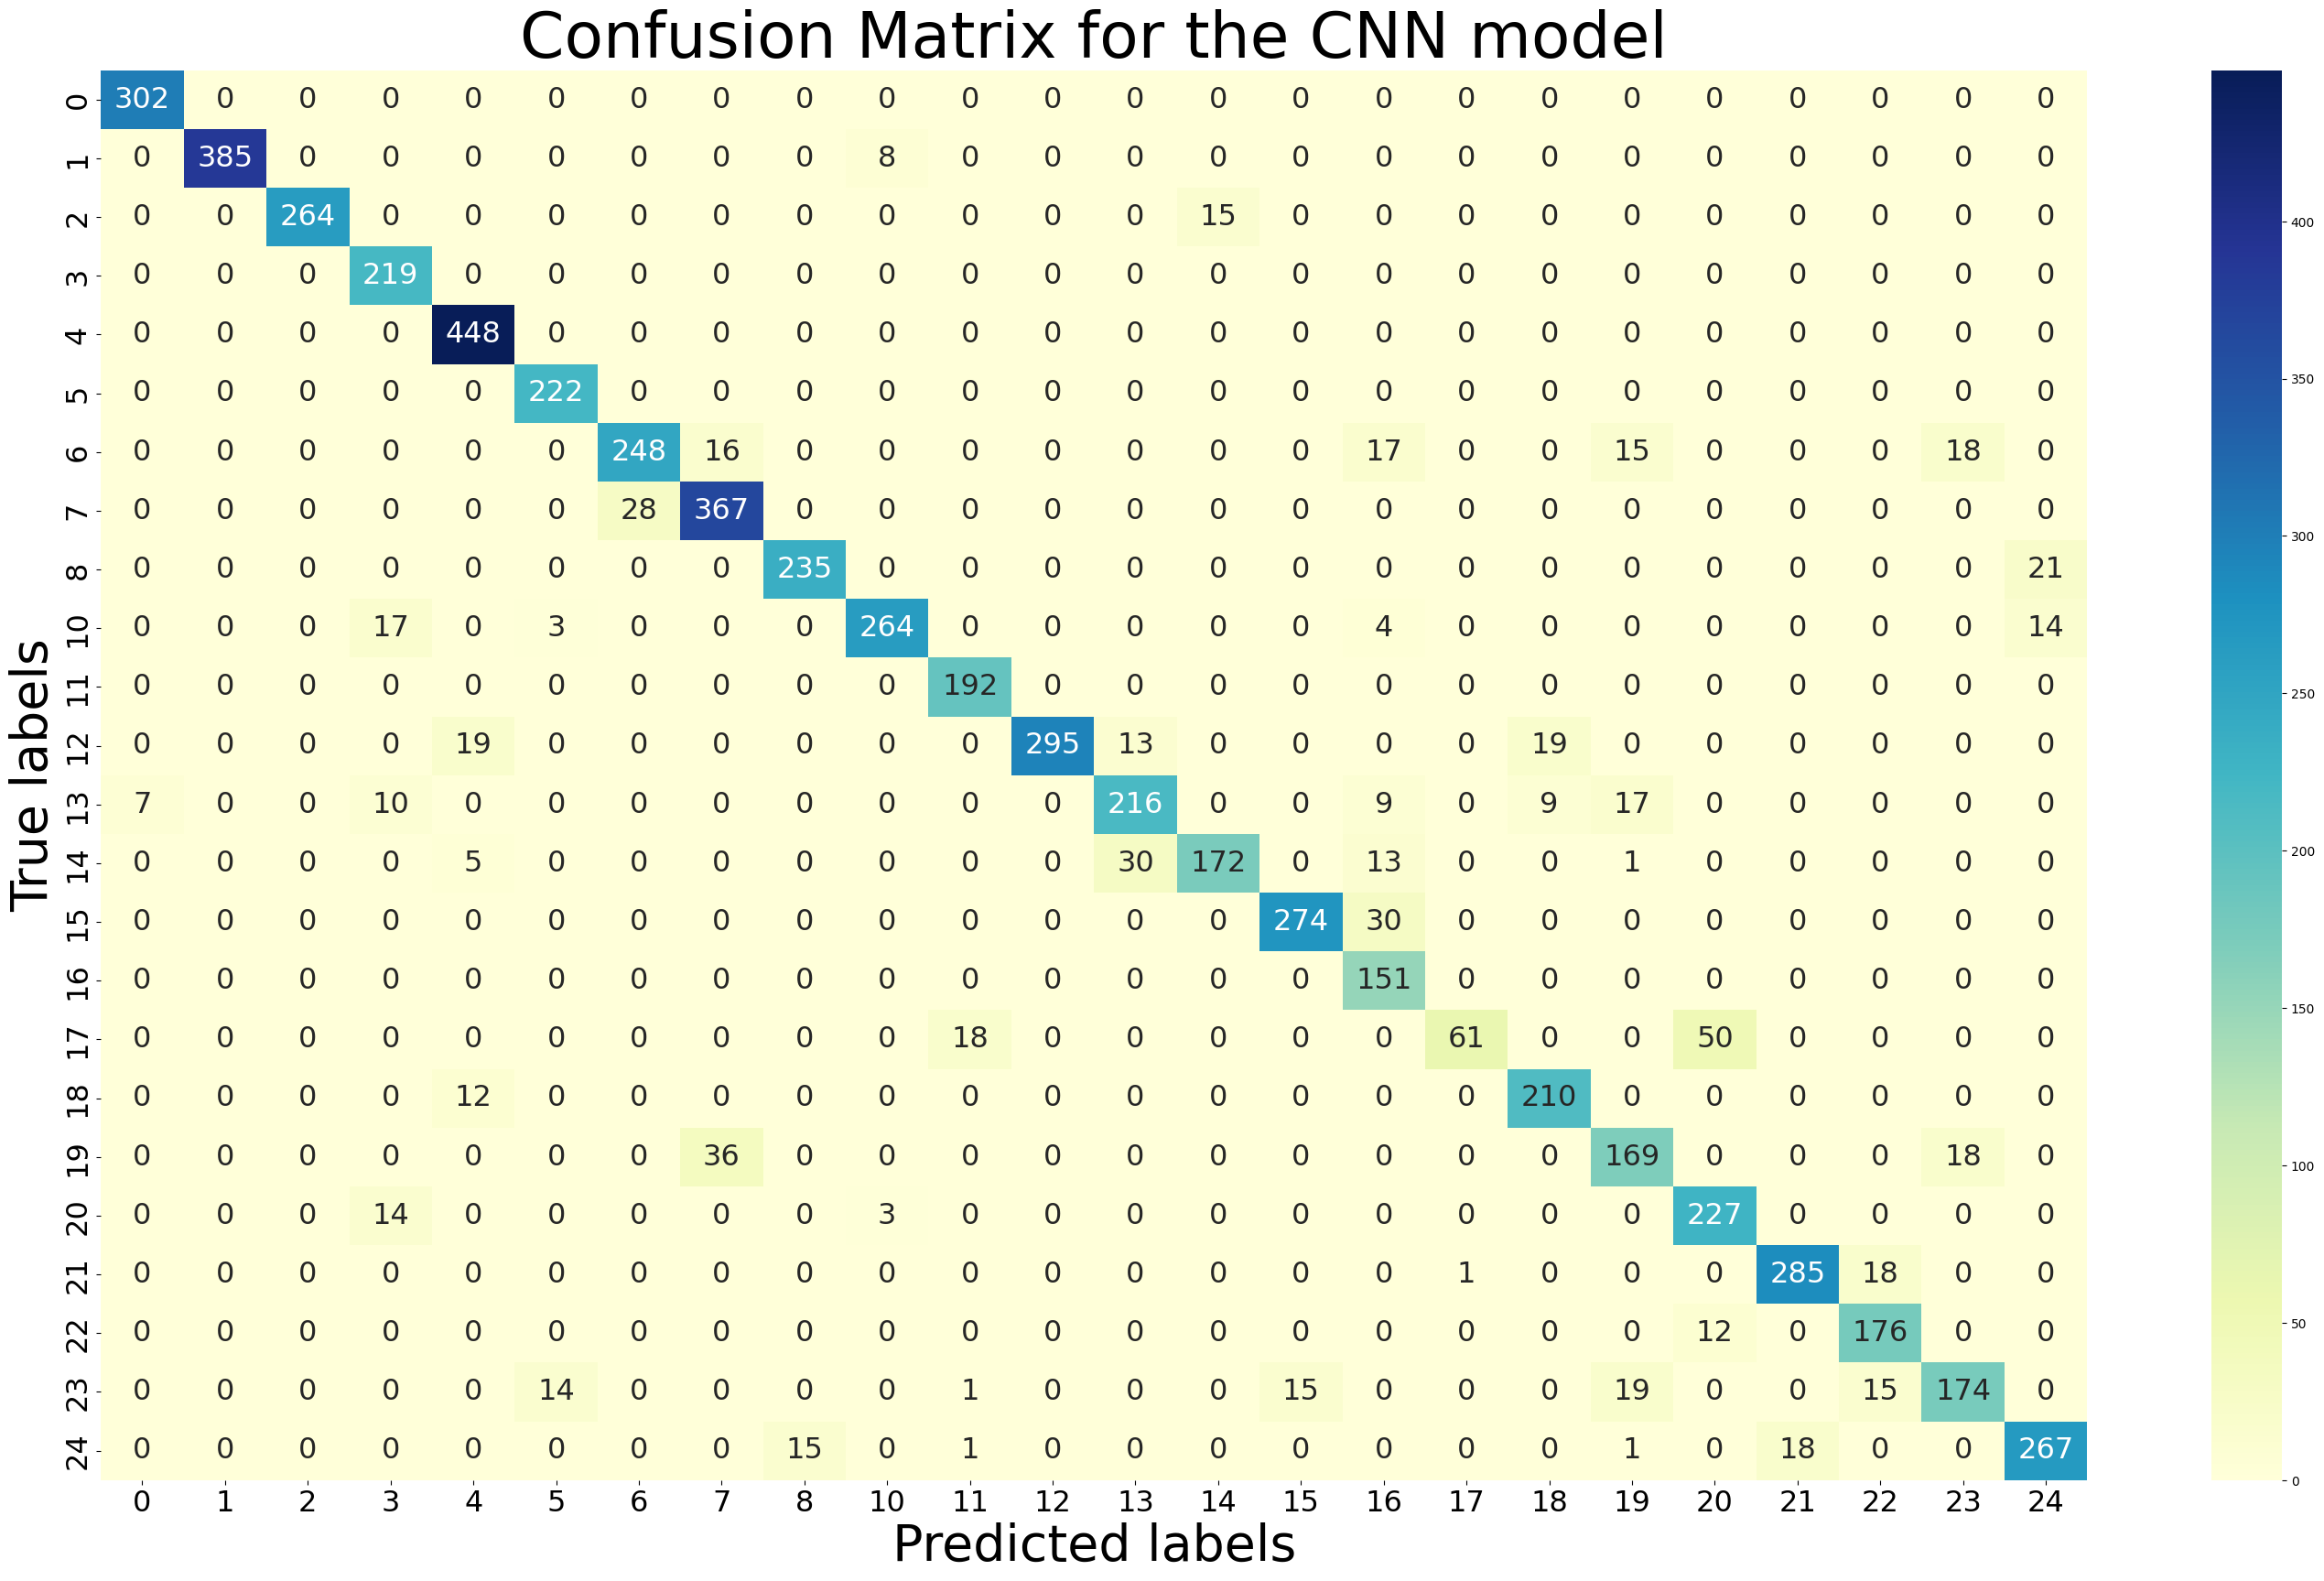

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# generate confusion matrix
con_matrix = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(35,20))
sns.heatmap(con_matrix,xticklabels=set(y_pred), yticklabels=set(y_pred),
            fmt='g',cmap="YlGnBu", annot=True,annot_kws={"size": 23})
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.xlabel('Predicted labels',fontsize=40);plt.ylabel('True labels',fontsize=40)
plt.title('Confusion Matrix for the CNN model',fontsize=50)
plt.show()

### 3. Hyper-parameter optimisation 
Take the base network from the previous part and perform hyper-parameter optimisation over the following 2 hyper-parameters. In both cases leave the layer sizes and other configurations constant.
We will try to optimisate the Hyper-parameters
1. Optimise the learning rate value. 
2. Optimise the L2 regularisation on the kernels in all layers. 

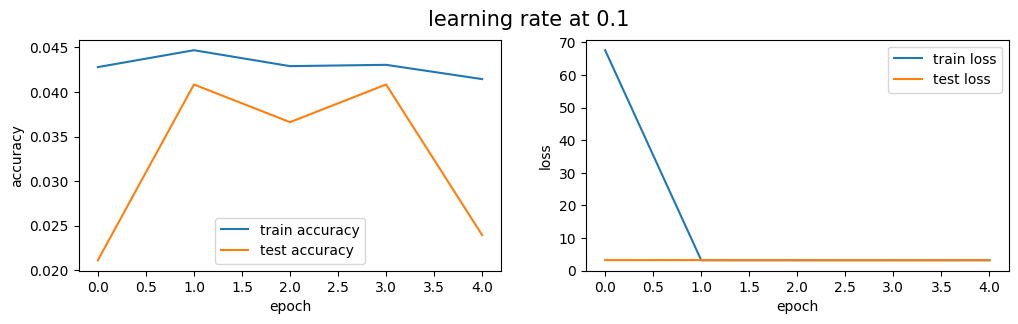

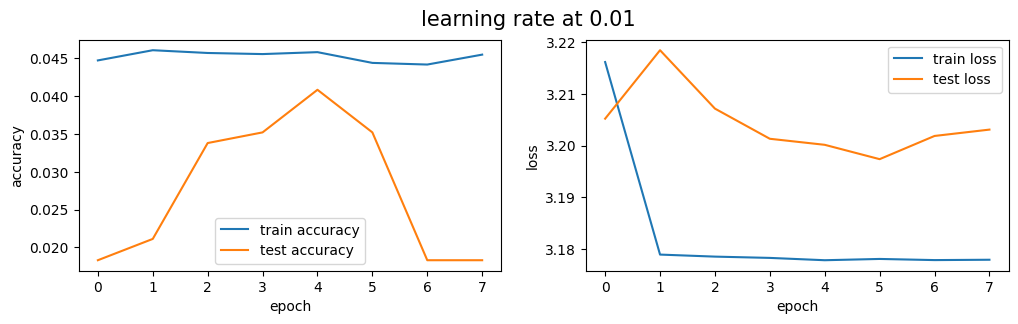

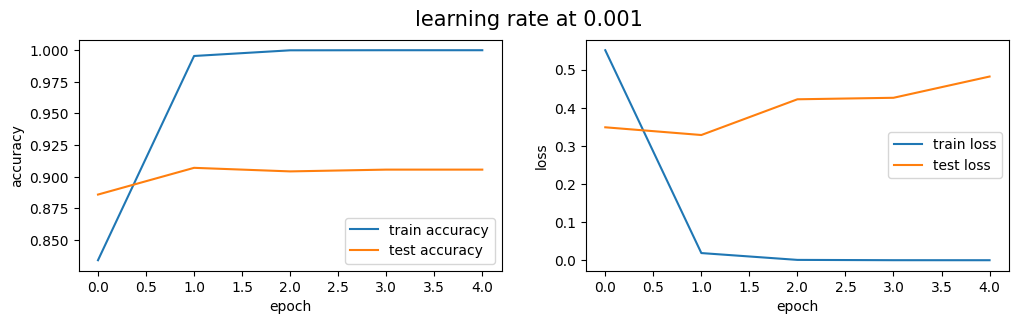

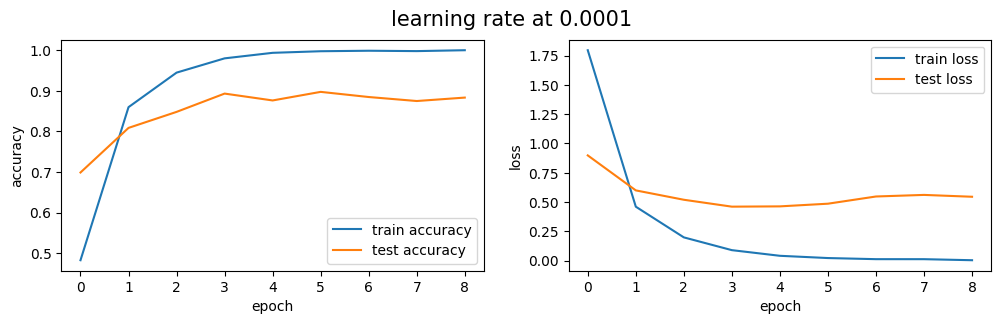

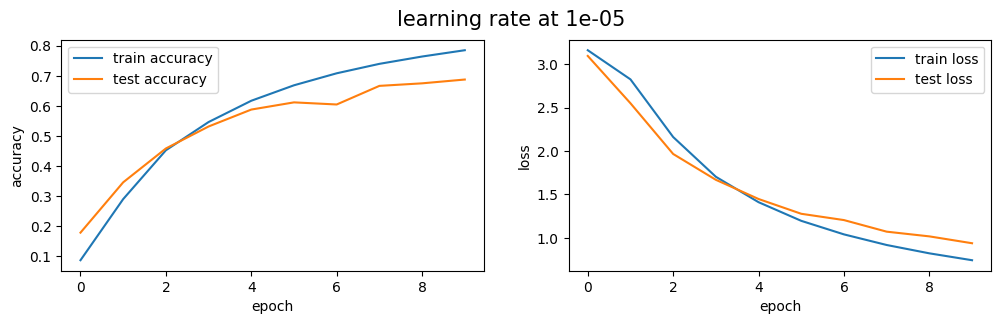

In [18]:
### Your code and answers here
# Optimise the learning rate value
learning_rates = [1E-1, 1E-2, 1E-3, 1E-4, 1E-5]
result = []
for lr in learning_rates:
    model = generate_CNN()
    model.compile(optimizer=keras.optimizers.Nadam(lr =lr),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=max_epochs,callbacks = [early_stopping],
                        validation_data = (X_valid,y_valid), verbose=0)
    eval_results = model.evaluate(X_test, y_test, verbose=0) 
    result.append([lr,eval_results[0],eval_results[1]])
    plot_history(history,'learning rate at '+ str(lr)) 

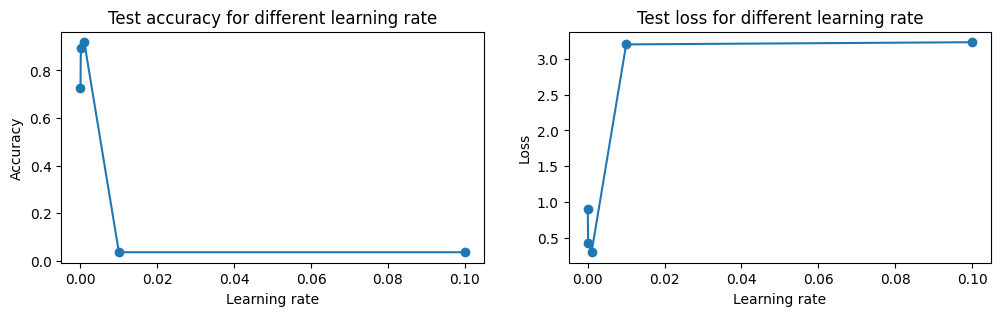

In [19]:
plt.figure(figsize=(12,3))
plt.subplot(121)
plt.plot(np.array(result)[:,0],np.array(result)[:,2],'-o')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.title('Test accuracy for different learning rate')
plt.subplot(122)
plt.plot(np.array(result)[:,0],np.array(result)[:,1],'-o')
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.title('Test loss for different learning rate')
plt.show()

* We see that the learning rate at 0.001 has the highest accuracy.We will use this learning rate to optimize L2 regularisation.

In [20]:
#add L2 regularisation to every layer
def add_L2regularizers(model,regularizer):
    for layer in model.layers:
        reg = 'kernel_regularizer'
        if hasattr(layer, reg):
            setattr(layer, reg, regularizer)
    return model

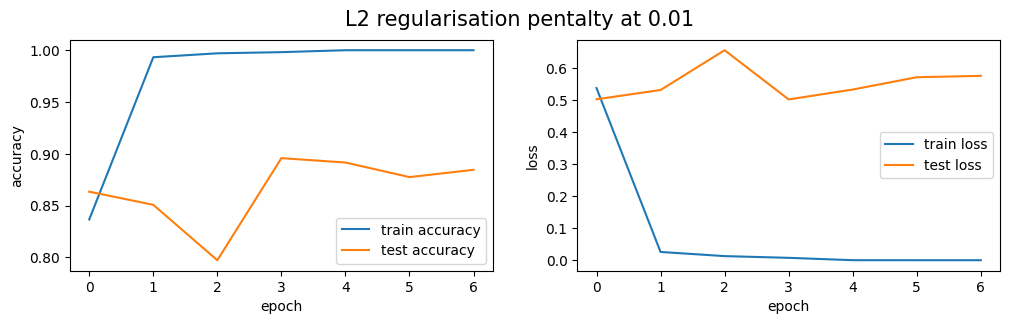

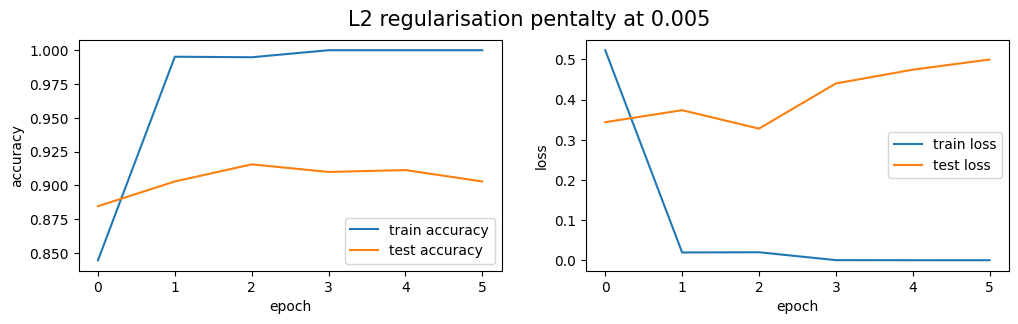

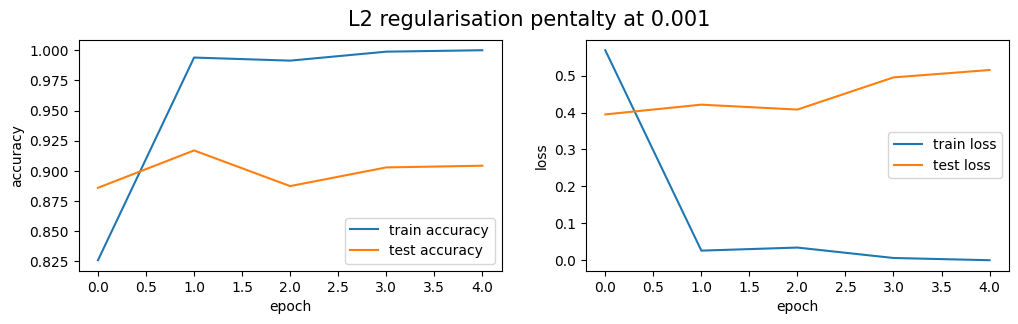

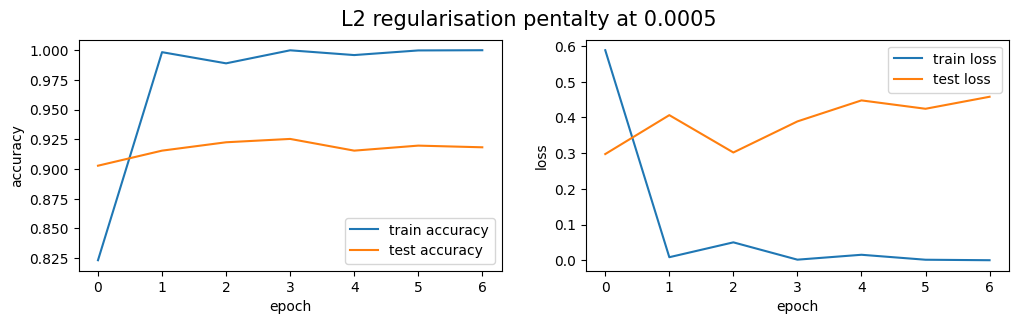

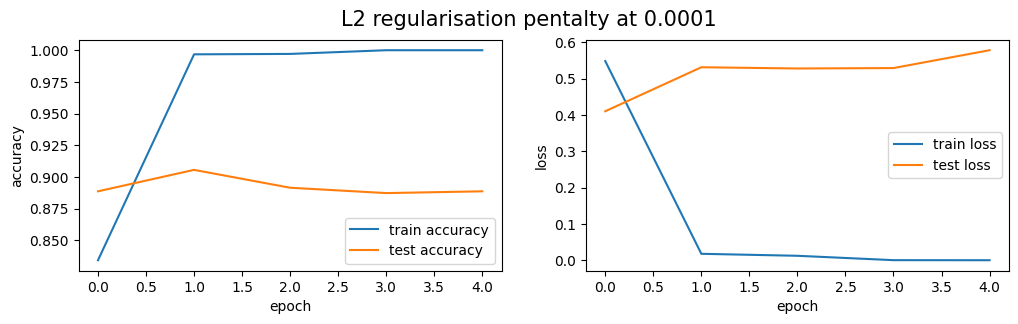

In [21]:
#Optimise the L2 regularisation
Penalty = [0.01,0.005,0.001,0.0005,0.0001]
L2_result = []
for p in Penalty:
    model = generate_CNN()
    regularizer = keras.regularizers.l2(p)
    model = add_L2regularizers(model,regularizer)
    model.compile(optimizer=keras.optimizers.Nadam(lr =0.001),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=max_epochs,callbacks = [early_stopping],
                        validation_data = (X_valid,y_valid), verbose=0)
    eval_results = model.evaluate(X_test, y_test, verbose=0) 
    L2_result.append([p,eval_results[0],eval_results[1]])
    plot_history(history,'L2 regularisation pentalty at '+ str(p)) 

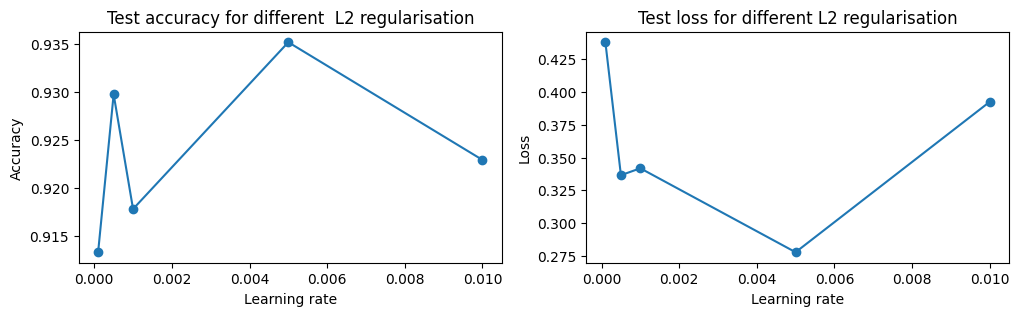

In [22]:
plt.figure(figsize=(12,3))
plt.subplot(121)
plt.plot(np.array(L2_result)[:,0],np.array(L2_result)[:,2],'-o')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.title('Test accuracy for different  L2 regularisation')
plt.subplot(122)
plt.plot(np.array(L2_result)[:,0],np.array(L2_result)[:,1],'-o')
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.title('Test loss for different L2 regularisation')
plt.show()

* From the graph we see that the L2 regularisation penalty at 0.005 has the highest accuracy at 0.001 learning rate.These are the best hyper-parameter values; the accuracy of the best hyper-parameter has increase the model's accuracy from 90.11% to above 93.5% on test data.

### 4. Larger CNN and ResNet 
In this part we will implement a larger version of the previous CNN as well as a ResNet version of this network. 
Implement a large CNN with the following architecture:
 - Layers: Conv32 - Conv32 - MaxPooling - Conv64 - Conv64 - MaxPooling - Conv128 - Conv128 - Flatten - Dense(100) - Output

In [23]:
### Your code and answers here
# Conv32 - Conv32 - MaxPooling - Conv64 - Conv64 - MaxPooling - Conv128 - Conv128 - Flatten - Dense(100)
def generate_largeCNN():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3,activation='relu', padding="same",input_shape=(28,28,1)))
    model.add(Conv2D(32, kernel_size=3, padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv2D(64, kernel_size=3, padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv2D(128, kernel_size=3, padding="same", activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(25, activation='softmax'))
    return model

In [24]:
# summary of the model
model = generate_largeCNN()
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_34 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 conv2d_36 (Conv2D)          (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                

In [25]:
#traing the model and keep the same settings
max_epochs = 10
model.compile(optimizer=keras.optimizers.Nadam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True) 
history = model.fit(X_train, y_train, epochs=max_epochs,callbacks = [early_stopping], validation_data = (X_valid,y_valid))

Epoch 1/10
858/858 [==============================] - 54s 62ms/step - loss: 0.6598 - accuracy: 0.8013 - val_loss: 0.3743 - val_accuracy: 0.8915
Epoch 2/10
858/858 [==============================] - 51s 60ms/step - loss: 0.0342 - accuracy: 0.9906 - val_loss: 0.7385 - val_accuracy: 0.8732
Epoch 3/10
858/858 [==============================] - 51s 60ms/step - loss: 0.0090 - accuracy: 0.9979 - val_loss: 0.6651 - val_accuracy: 0.9056
Epoch 4/10
858/858 [==============================] - 49s 57ms/step - loss: 0.0204 - accuracy: 0.9936 - val_loss: 0.5867 - val_accuracy: 0.8944
Epoch 5/10
858/858 [==============================] - 50s 58ms/step - loss: 0.0187 - accuracy: 0.9949 - val_loss: 0.6030 - val_accuracy: 0.8944
Epoch 6/10
858/858 [==============================] - 49s 57ms/step - loss: 3.1612e-04 - accuracy: 1.0000 - val_loss: 0.6289 - val_accuracy: 0.9141
Epoch 7/10
858/858 [==============================] - 49s 57ms/step - loss: 9.3216e-06 - accuracy: 1.0000 - val_loss: 0.6965 - val_a

Loss on test data: 0.53
Accuracy on test data: 93.14%


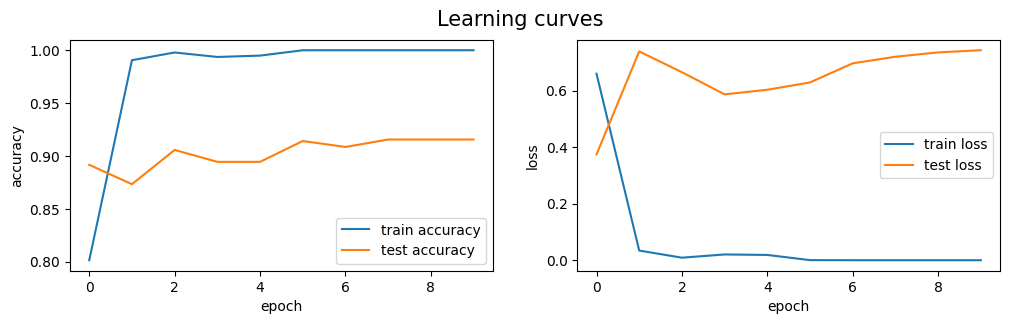

In [26]:
#performance of the large CNN
eval_results = model.evaluate(X_test, y_test, verbose=0) 
print("Loss on test data: " + str(round(eval_results[0],2)))
print("Accuracy on test data: "   +'%s%%'%(round(eval_results[1]*100,2)))
plot_history(history,'Learning curves')

In [27]:
#add ResidualUnit
class ResidualUnit (keras.layers.Layer): 
    def __init__ (self, filters, strides=1, activation="relu", **kwargs): 
        super(). __init__ (**kwargs) 
        self.activation = keras.activations.get(activation) 
        self.main_layers = [ 
            keras.layers.Conv2D(filters, 3, strides=strides, 
                                padding="same", use_bias=False),  
            self.activation, 
            keras.layers.Conv2D(filters, 3, strides=1, 
                                padding="same", use_bias=False)] 
        self.skip_layers = [] 
        if strides > 1: 
            self.skip_layers = [ 
                keras.layers.Conv2D(filters, 1, strides=strides, 
                                    padding="same", use_bias=False)] 
            
    def call(self, inputs): 
        Z = inputs 
        for layer in self.main_layers: 
            Z = layer(Z) 
        skip_Z = inputs 
        for layer in self.skip_layers: 
            skip_Z = layer(skip_Z) 
        return self.activation(Z + skip_Z)

In [28]:
# Resnet
initial_filters=32
residual_unit_filters=[32, 64, 128]
actfn = 'relu'

model = keras.models.Sequential() 
model.add(keras.layers.Conv2D(initial_filters, 3, strides=2, 
                              input_shape=[28, 28, 1], 
                              padding="same", use_bias=False))
model.add(keras.layers.Activation(actfn)) 
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = initial_filters
for filters in residual_unit_filters: 
    if filters == prev_filters: 
        strides = 1
    else:
        strides = 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters 
    
model.add(keras.layers.GlobalAvgPool2D()) 
model.add(keras.layers.Flatten()) 
model.add(Dense(25, activation='sigmoid'))

model.compile(optimizer=keras.optimizers.Nadam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])  

# Output the model summary
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 14, 14, 32)        288       
                                                                 
 activation (Activation)     (None, 14, 14, 32)        0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 residual_unit (ResidualUnit  (None, 7, 7, 32)         18432     
 )                                                               
                                                                 
 residual_unit_1 (ResidualUn  (None, 4, 4, 64)         57344     
 it)                                                             
                                                     

In [29]:
#train the restnet
history = model.fit(X_train, y_train, epochs=max_epochs,callbacks = [early_stopping], validation_data = (X_valid,y_valid))

Epoch 1/10
858/858 [==============================] - 9s 9ms/step - loss: 0.8529 - accuracy: 0.7264 - val_loss: 0.5212 - val_accuracy: 0.8732
Epoch 2/10
858/858 [==============================] - 8s 9ms/step - loss: 0.0390 - accuracy: 0.9888 - val_loss: 1.1359 - val_accuracy: 0.7944
Epoch 3/10
858/858 [==============================] - 8s 9ms/step - loss: 0.0284 - accuracy: 0.9911 - val_loss: 0.5478 - val_accuracy: 0.9085
Epoch 4/10
858/858 [==============================] - 8s 9ms/step - loss: 0.0108 - accuracy: 0.9967 - val_loss: 0.5299 - val_accuracy: 0.9183
Epoch 5/10
858/858 [==============================] - 7s 9ms/step - loss: 9.4611e-05 - accuracy: 1.0000 - val_loss: 0.6039 - val_accuracy: 0.9183
Epoch 6/10
858/858 [==============================] - 7s 9ms/step - loss: 2.2326e-05 - accuracy: 1.0000 - val_loss: 0.6279 - val_accuracy: 0.9225
Epoch 7/10
858/858 [==============================] - 8s 9ms/step - loss: 1.0094e-05 - accuracy: 1.0000 - val_loss: 0.6524 - val_accuracy: 0

Loss on test data: 0.68
Accuracy on test data: 91.63%


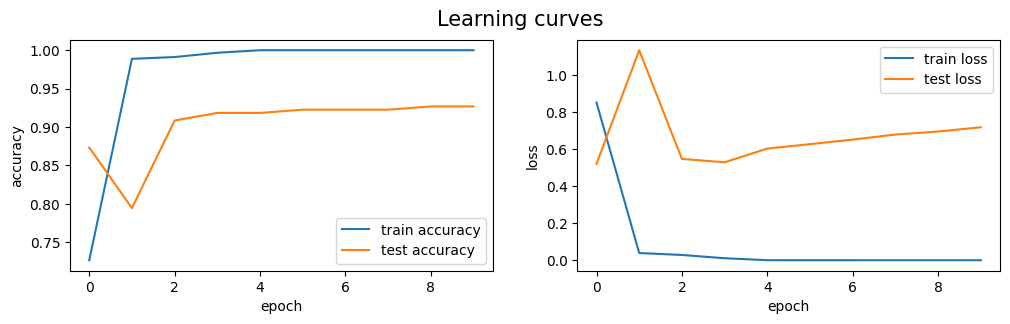

In [30]:
# performace of the resnet
eval_results = model.evaluate(X_test, y_test, verbose=0) 
print("Loss on test data: " + str(round(eval_results[0],2)))
print("Accuracy on test data: "   +'%s%%'%(round(eval_results[1]*100,2)))
plot_history(history,'Learning curves')

* Resnet has better performance than the large CNN, with an accuracy of 91.63% compared with the large CNN with 93.14% accuracy, so far our first CNN model is our best model with the highest accuracy.

### 5. Final evaluation 
1. Compare the networks using accuracy and choose the best network 

In [31]:
### Your code and answers here
# our best model is L2 regularisation penalty at 0.01 and 0.001 learning rate
model = generate_CNN()
regularizer = keras.regularizers.l2(0.005)
best_model = add_L2regularizers(model,regularizer)
best_model.compile(optimizer=keras.optimizers.Nadam(lr =0.001),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = best_model.fit(X_train, y_train, epochs=max_epochs,callbacks = [early_stopping],
                        validation_data = (X_valid,y_valid), verbose=0)
eval_results = best_model.evaluate(X_test, y_test, verbose=0) 

Loss on test data: 0.39
Accuracy on test data: 94.18%


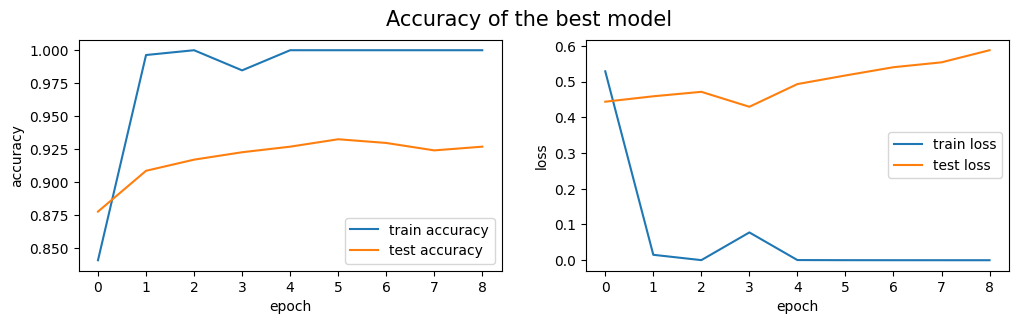

In [32]:
#performace of our best model
print("Loss on test data: " + str(round(eval_results[0],2)))
print("Accuracy on test data: "   +'%s%%'%(round(eval_results[1]*100,2)))
plot_history(history,'Accuracy of the best model')

In [33]:
y_pred =np.argmax(best_model.predict(X_test), axis=-1)
cm = multilabel_confusion_matrix(y_test,y_pred)
print( classification_report(y_test,y_pred))

202/202 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       302
         1.0       1.00      1.00      1.00       393
         2.0       1.00      1.00      1.00       279
         3.0       0.99      1.00      1.00       219
         4.0       0.93      1.00      0.96       448
         5.0       0.98      1.00      0.99       222
         6.0       0.95      0.94      0.95       314
         7.0       0.96      0.96      0.96       395
         8.0       0.94      0.93      0.94       256
        10.0       1.00      0.93      0.96       302
        11.0       0.99      1.00      1.00       192
        12.0       0.91      0.88      0.90       346
        13.0       0.89      0.97      0.93       268
        14.0       1.00      0.67      0.80       221
        15.0       1.00      1.00      1.00       304
        16.0       0.93      0.87      0.90       151
        17.0       0.98   

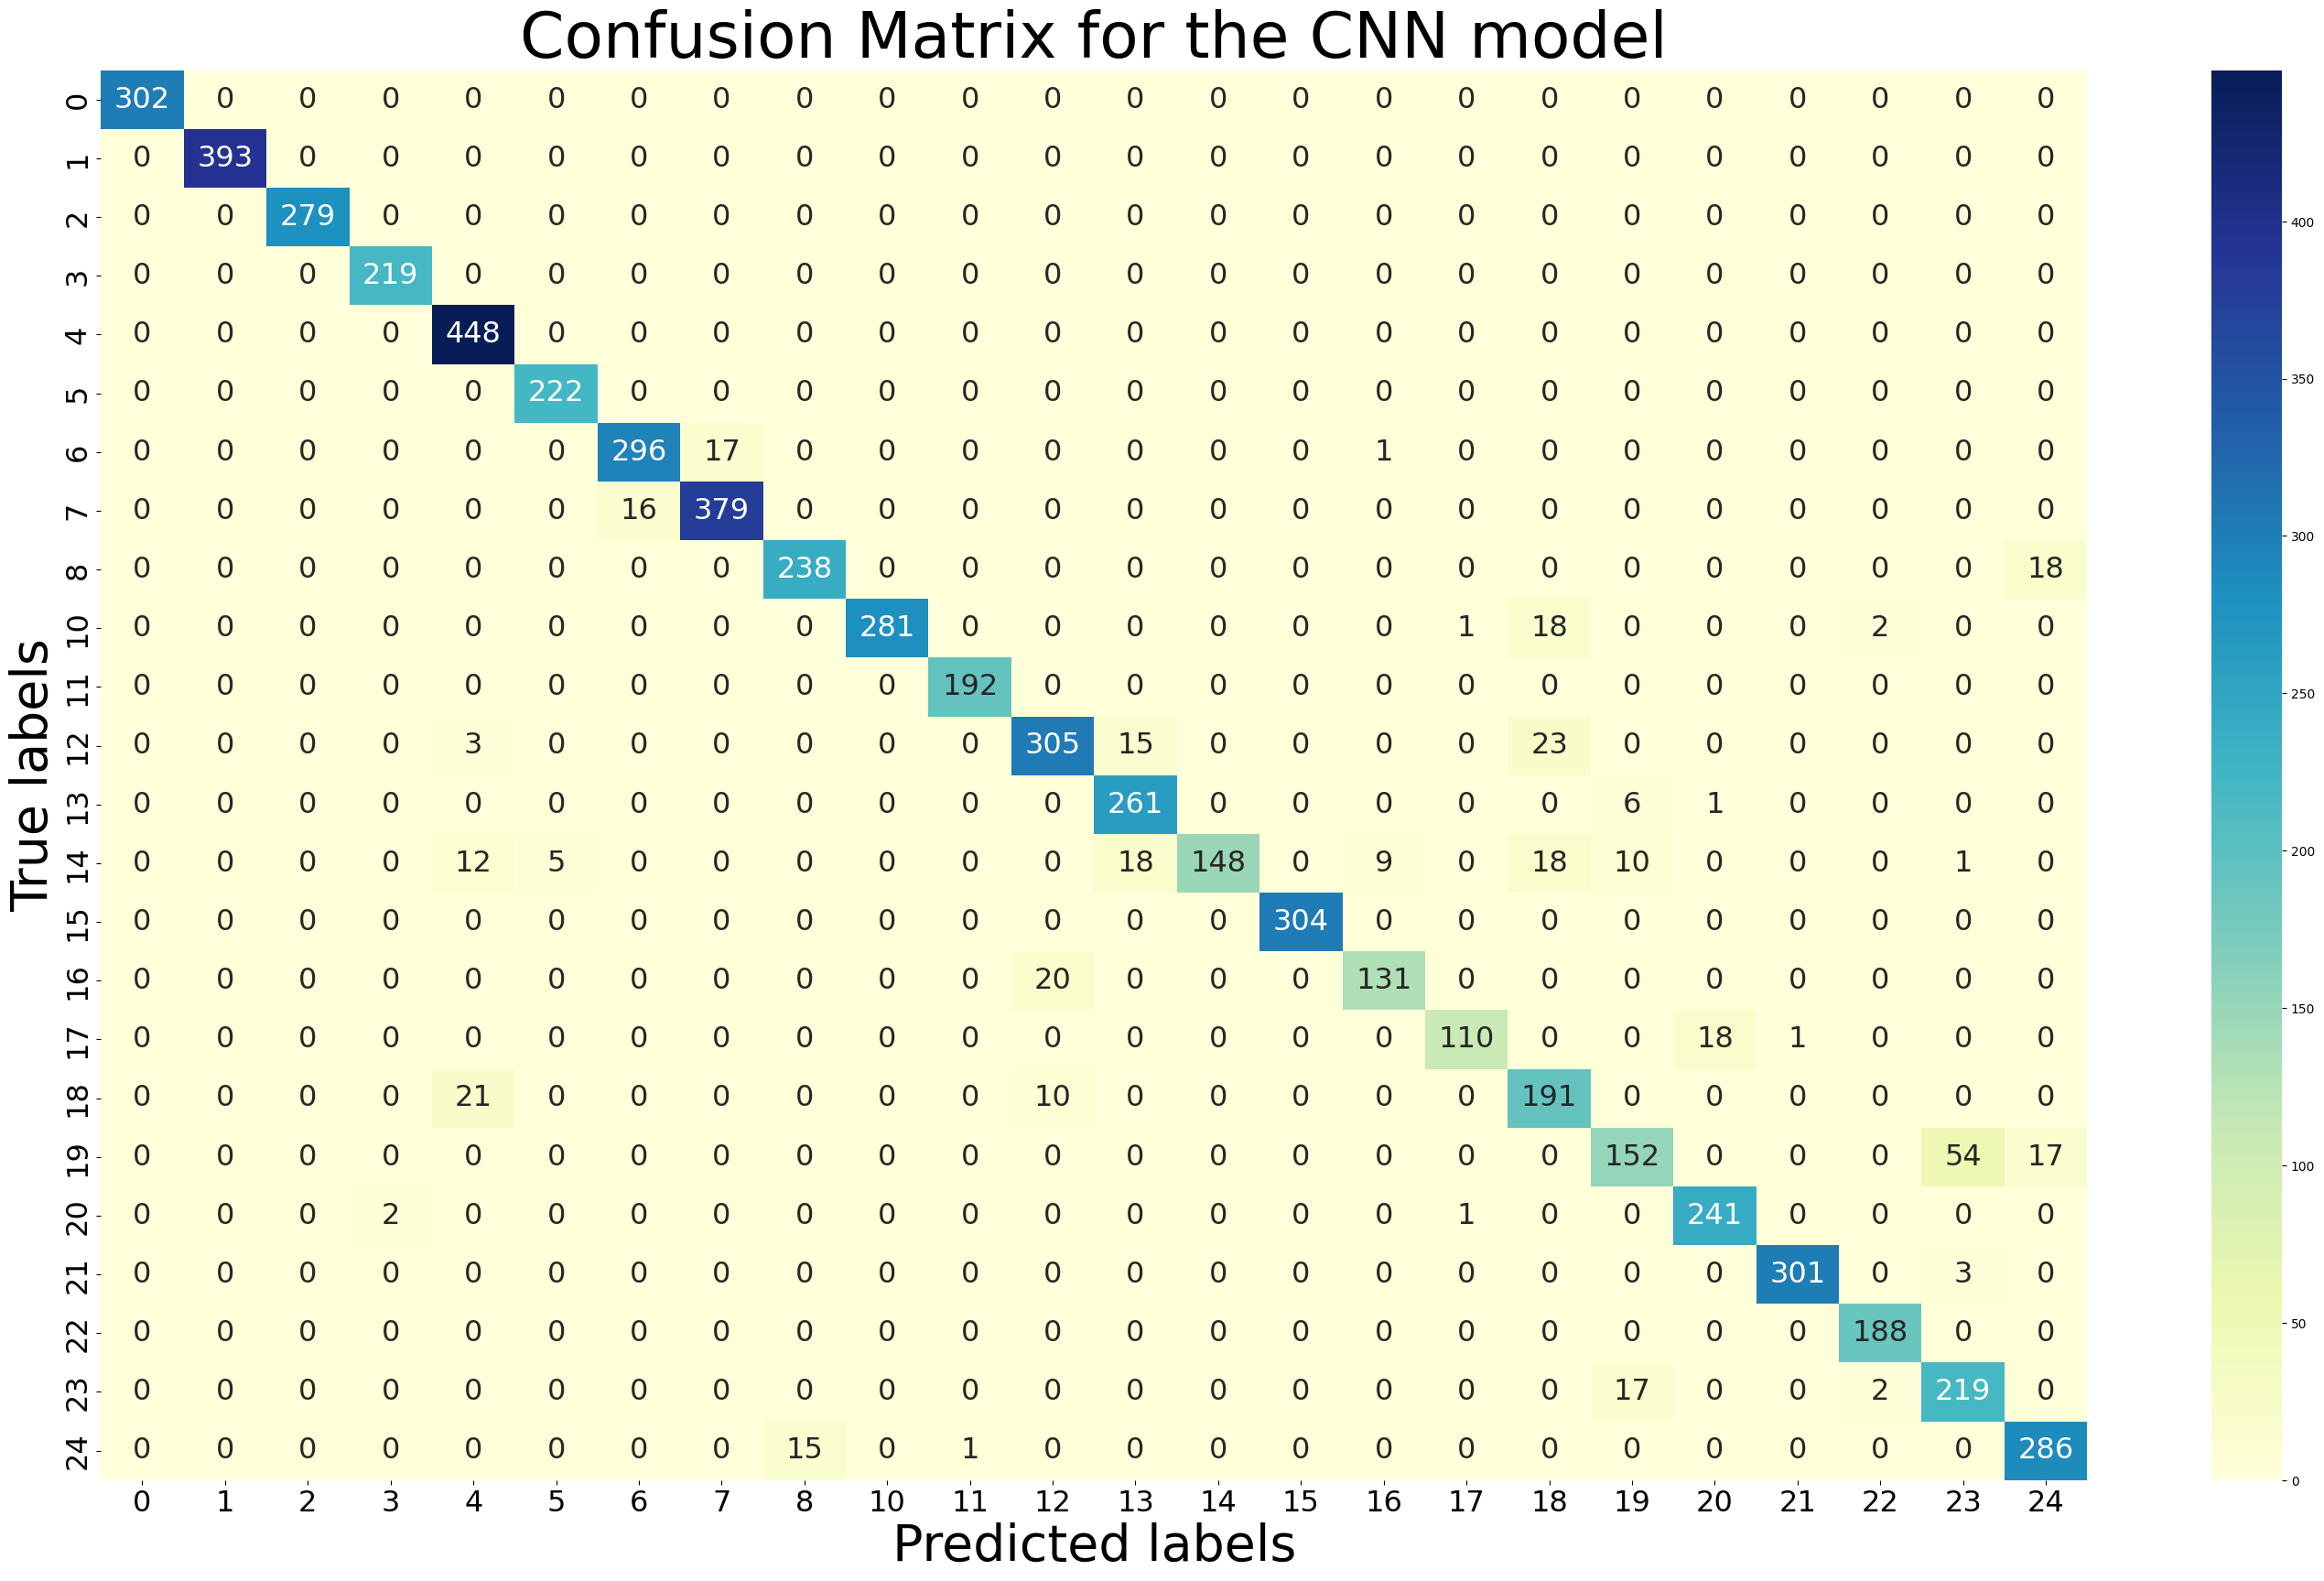

In [34]:
con_matrix = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(35,20))
sns.heatmap(con_matrix,xticklabels=set(y_pred), yticklabels=set(y_pred),
            fmt='g',cmap="YlGnBu", annot=True,annot_kws={"size": 23})
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.xlabel('Predicted labels',fontsize=40);plt.ylabel('True labels',fontsize=40)
plt.title('Confusion Matrix for the CNN model',fontsize=50)
plt.show()

* Class 19 is most often incorrectly classified and most commonly mistaken for Class 23. We can see from the F1 score that class 19 has the lowest F1 score and from the confusion matrix we can see that 54 of class 19 were mistaken as class 23.

### 6. Joint Optimisation 

In this section there we will try to optimze the following hypmeters:
 - Activation function
 - Optimiser
 - Kernal size

In [35]:
# the parameters we are going to test
Optimiser = [keras.optimizers.Adamax(),keras.optimizers.Adagrad(),keras.optimizers.SGD()]
Activation = ['tanh','selu','softmax']
kernal = [4,5,6]

In [36]:
# use the smae layer setting of our best model
def generate_testCNN(Activation,kernal):
    model = Sequential()
    model.add(Conv2D(32, kernel_size= kernal,activation=Activation, padding="same",input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size= kernal, padding="same", activation=Activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size= kernal, padding="same", activation=Activation))
    model.add(Flatten())
    model.add(Dense(100, activation=Activation))
    model.add(Dense(25, activation='softmax'))
    return model

Loss on test data: 0.26
Accuracy on test data: 93.92%


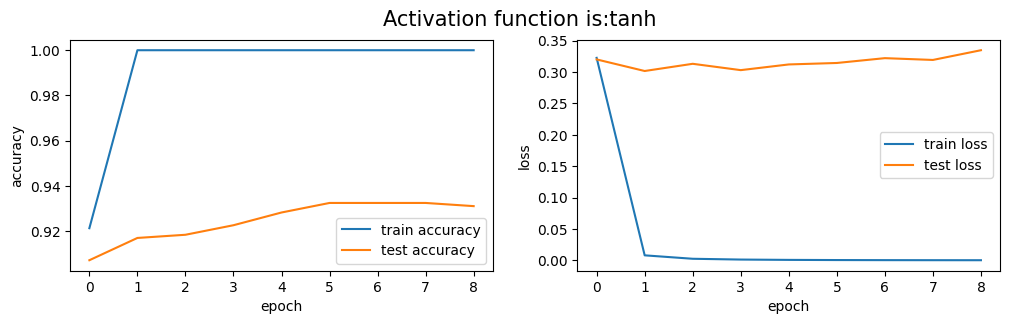

Loss on test data: 0.48
Accuracy on test data: 91.6%


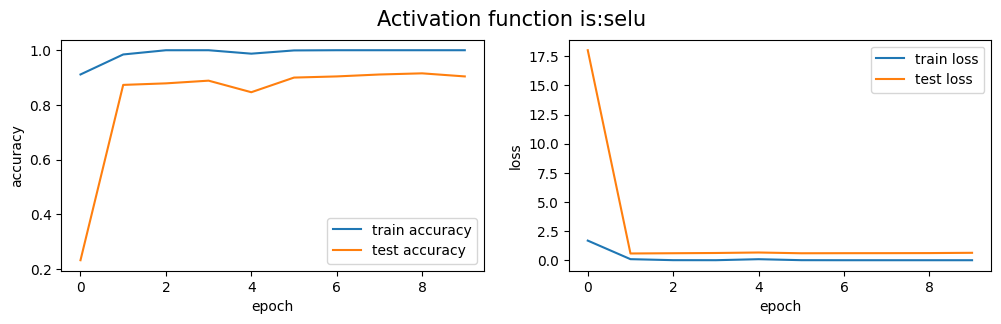

Loss on test data: 2.26
Accuracy on test data: 18.12%


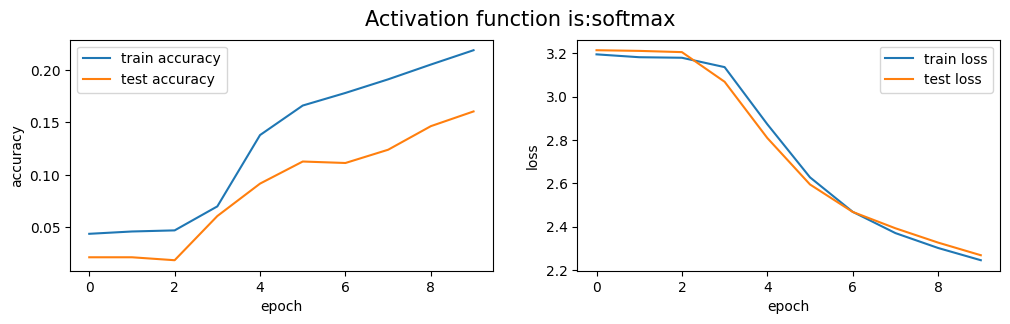

In [37]:
import timeit
# test the activation and keep other setting same with our best model
test_result= []
for act in Activation:
    model = generate_testCNN(act,3)
    regularizer = keras.regularizers.l2(0.005)
    model = add_L2regularizers(model,regularizer)
    model.compile(optimizer=keras.optimizers.Nadam(),
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    tic=timeit.default_timer()
    history = model.fit(X_train, y_train, epochs=max_epochs,callbacks = [early_stopping],
                        validation_data = (X_valid,y_valid), verbose=0)
    toc=timeit.default_timer()
    eval_results = model.evaluate(X_test, y_test, verbose=0) 
    test_result.append([eval_results[0],eval_results[1],toc-tic])
    print("Loss on test data: " + str(round(eval_results[0],2)))
    print("Accuracy on test data: "   +'%s%%'%(round(eval_results[1]*100,2)))
    plot_history(history,'Activation function is:' + str(act))

In [38]:
pd.DataFrame({'Activation function ':Activation,'loss':  np.array(test_result)[:,0] ,
              'accuracy': np.array(test_result)[:,1],'training time(s)': np.array(test_result)[:,2]})

,Activation function,loss,accuracy,training time(s)
0,tanh,0.259613,0.939183,154.971789
1,selu,0.476423,0.915970,170.161252
2,softmax,2.255177,0.181213,183.815029


* We can see that the change of activation function has not increased the accuracy, we will keep the originoal activation function

Loss on test data: 0.25
Accuracy on test data: 94.92%


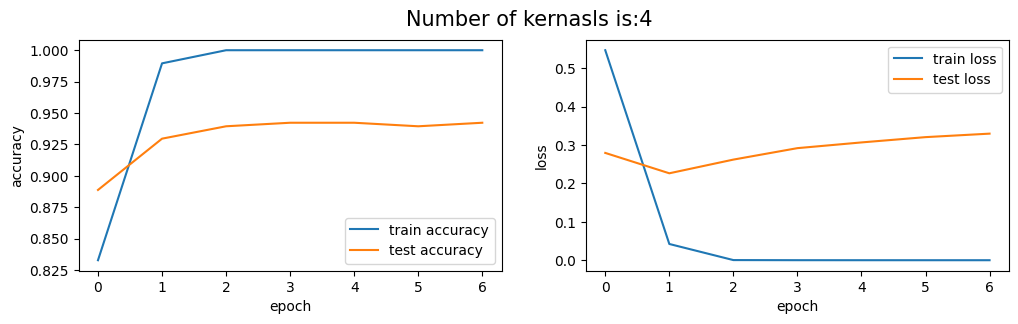

Loss on test data: 0.33
Accuracy on test data: 91.57%


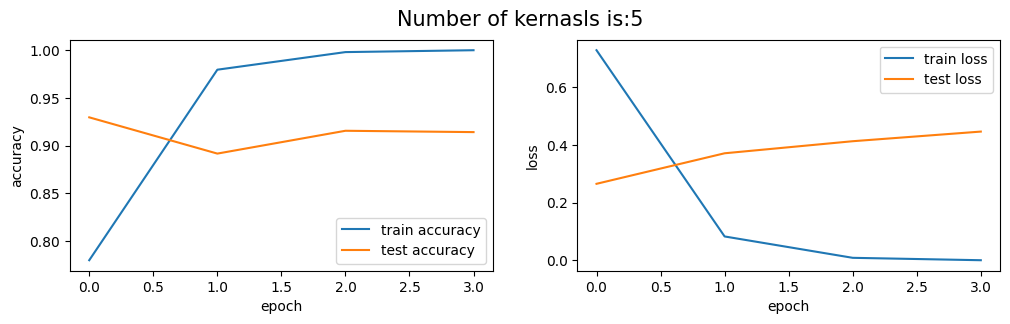

Loss on test data: 0.26
Accuracy on test data: 93.79%


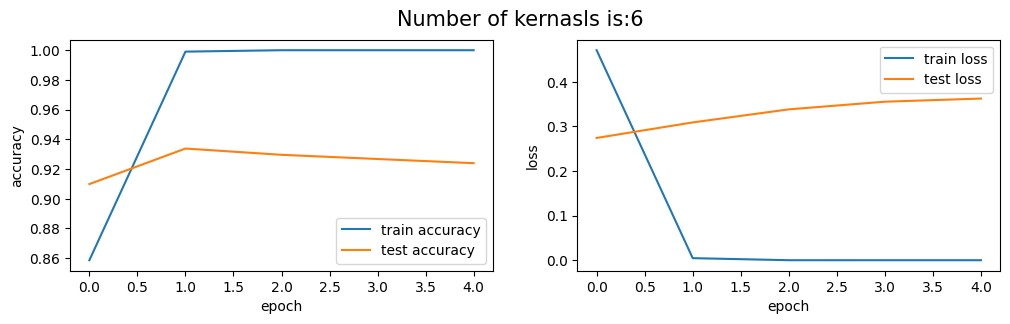

In [44]:
test_result= []
# test the number of filiters in the in the Conv layers
for k in kernal:
    model = generate_testCNN('relu',k)
    regularizer = keras.regularizers.l2(0.005)
    model = add_L2regularizers(model,regularizer)
    model.compile(optimizer=keras.optimizers.Nadam(),
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    tic=timeit.default_timer()
    history = model.fit(X_train, y_train, epochs=max_epochs,callbacks = [early_stopping],
                        validation_data = (X_valid,y_valid), verbose=0)
    toc=timeit.default_timer()
    eval_results = model.evaluate(X_test, y_test, verbose=0) 
    test_result.append([eval_results[0],eval_results[1],toc-tic])
    print("Loss on test data: " + str(round(eval_results[0],2)))
    print("Accuracy on test data: "   +'%s%%'%(round(eval_results[1]*100,2)))
    plot_history(history,'Number of kernasls is:' + str(k))

In [45]:
# performce
pd.DataFrame({'kernal size ':kernal,'loss':  np.array(test_result)[:,0] ,
              'accuracy': np.array(test_result)[:,1],'training time(s)': np.array(test_result)[:,2]})

,kernal size,loss,accuracy,training time(s)
0,4,0.245120,0.949242,151.975961
1,5,0.334541,0.915661,113.016705
2,6,0.261382,0.937945,188.149599


* From the performance results, we see the accuracy increase when we increase the number of filters in the layer to 4.

Loss on test data: 0.39
Accuracy on test data: 91.23%


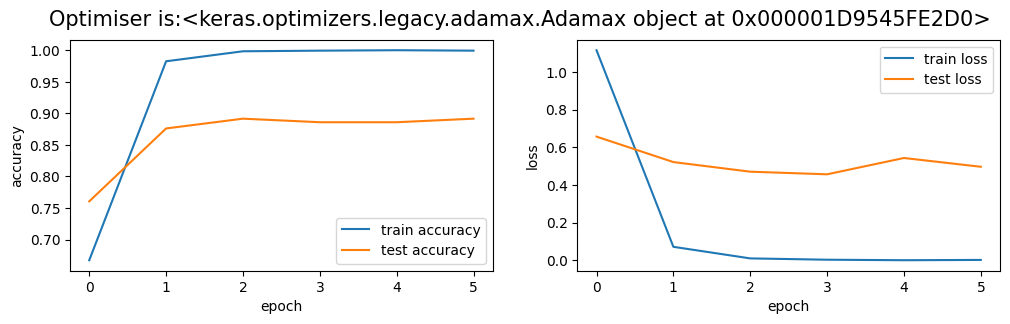

Loss on test data: 1.13
Accuracy on test data: 62.15%


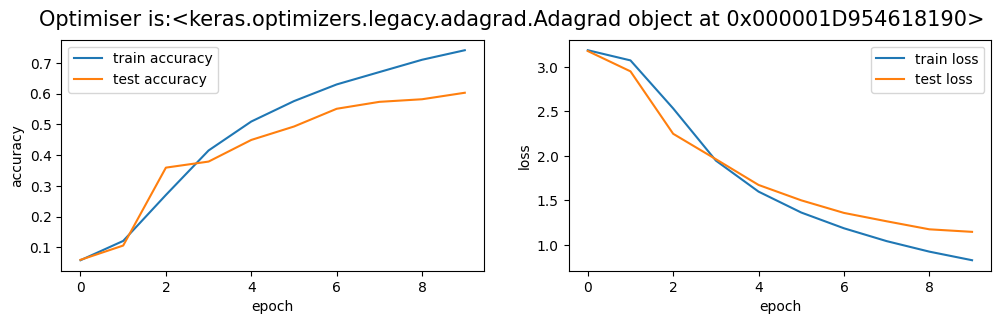

Loss on test data: 0.5
Accuracy on test data: 89.11%


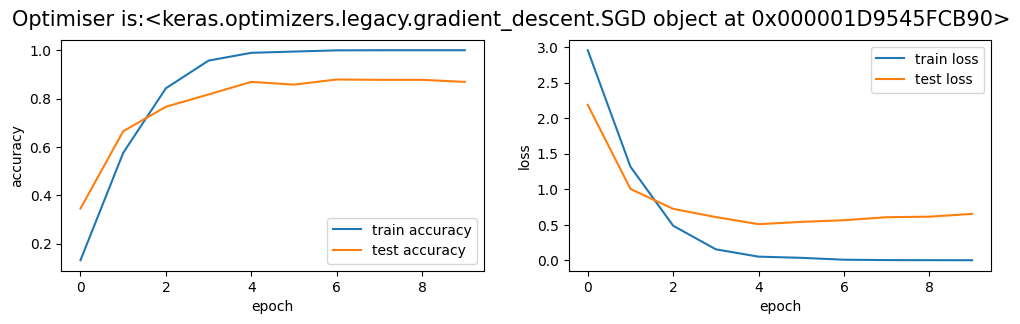

In [46]:
test_result= []
#test optimiser
for opt in Optimiser:
    model = generate_testCNN('relu',4)
    regularizer = keras.regularizers.l2(0.005)
    model = add_L2regularizers(model,regularizer)
    model.compile(optimizer=opt,
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    tic=timeit.default_timer()
    history = model.fit(X_train, y_train, epochs=max_epochs,callbacks = [early_stopping],
                        validation_data = (X_valid,y_valid), verbose=0)
    toc=timeit.default_timer()
    eval_results = model.evaluate(X_test, y_test, verbose=0) 
    test_result.append([eval_results[0],eval_results[1],toc-tic])
    print("Loss on test data: " + str(round(eval_results[0],2)))
    print("Accuracy on test data: "   +'%s%%'%(round(eval_results[1]*100,2)))
    plot_history(history,'Optimiser is:' + str(opt))

In [47]:
pd.DataFrame({'Optimiser':Optimiser,'loss':  np.array(test_result)[:,0] ,
              'accuracy': np.array(test_result)[:,1],'training time(s)': np.array(test_result)[:,2]})

,Optimiser,loss,accuracy,training time(s)
0,<keras.optimizers.legacy.adamax.Adamax object ...,0.387550,0.912256,113.805254
1,<keras.optimizers.legacy.adagrad.Adagrad objec...,1.128432,0.621479,189.832391
2,<keras.optimizers.legacy.gradient_descent.SGD ...,0.501212,0.891055,171.864133


* From the accuracy table we see that the optimizer adamax has the highest accuracy of 91.23% among other optimizers and a stable learning curve. But our accuracy has not increased by change the Optimiser, we will keep the Nadam optimizer.

In [48]:
# Train and save our best model
best_model = generate_testCNN('relu',4)
regularizer = keras.regularizers.l2(0.005)
best_model = add_L2regularizers(best_model,regularizer)
best_model.compile(optimizer=keras.optimizers.Nadam(),
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
best_model.fit(X_train, y_train, epochs=max_epochs,callbacks = [early_stopping],validation_data = (X_valid,y_valid), verbose=0)
eval_results = best_model.evaluate(X_test, y_test, verbose=0) 
print("Loss on test data: " + str(round(eval_results[0],2)))
print("Accuracy on test data: "   +'%s%%'%(round(eval_results[1]*100,2)))
# save model structure to single file
best_model.save("best_model.h5")
print("Saved model to disk")

Loss on test data: 0.34
Accuracy on test data: 93.83%
Saved model to disk
